In [116]:
# all the linear positions
pip install filterpy
from filterpy.common import Q_continuous_white_noise
import numpy as np

def norm(x) -> np.ndarray:
    '''
    args
    nd vector

    returns normalized vector or 0 vector if magnitude is 0
    '''
    norm = np.linalg.norm(x)
    if (norm != 0):
        return x.copy()/norm
    return np.zeros(np.shape(x))

def body_to_world(roll, pitch, yaw, body_vector):
    roll = np.array([[1, 0, 0], [0, np.cos(roll), -np.sin(roll)], [0, np.sin(roll), np.cos(roll)]])
    pitch = np.array([[np.cos(pitch), 0, np.sin(pitch)], [0, 1, 0], [-np.sin(pitch), 0, np.cos(pitch)]])
    yaw = np.array([[np.cos(yaw), -np.sin(yaw), 0], [np.sin(yaw), np.cos(yaw), 0], [0, 0, 1]])
    return yaw @ pitch @ roll @ body_vector

def world_to_body(roll, pitch, yaw, world_vector):
    roll = np.array([[1, 0, 0], [0, np.cos(roll), -np.sin(roll)], [0, np.sin(roll), np.cos(roll)]])
    pitch = np.array([[np.cos(pitch), 0, np.sin(pitch)], [0, 1, 0], [-np.sin(pitch), 0, np.cos(pitch)]])
    yaw = np.array([[np.cos(yaw), -np.sin(yaw), 0], [np.sin(yaw), np.cos(yaw), 0], [0, 0, 1]])
    return (yaw @ pitch @ roll).T @ world_vector

class KalmanFilter:
    """Kalman Filter for 3D position estimation

    Args:
        dt (float): time step
        pos_x (float): initial x position
        vel_x (float): initial x velocity
        accel_x (float): initial x acceleration
        pos_y (float): initial y position
        vel_y (float): initial y velocity
        accel_y (float): initial y acceleration
        pos_z (float): initial z position
        vel_z (float): initial z velocity
        accel_z (float): initial z acceleration
    """
    def __init__(self, dt, pos_x, vel_x, accel_x, pos_y, vel_y, accel_y, pos_z, vel_z, accel_z):
        self.dt = dt
        self.x_k = np.zeros((9,1))
        self.Q = np.zeros((9,9))
        self.R = np.diag([2., 1.9, 1.9, 1.9])
        self.P_k = np.zeros((9,9))
        self.x_priori = np.zeros((9,1))
        self.P_priori = np.zeros((9,9))
        self.F = np.zeros((9,9))
        self.H = np.zeros((4,9))

        self.current_time = 0
        self.s_dt = dt

        self.x_k = np.array([pos_x, vel_x, accel_x, pos_y, vel_y, accel_y, pos_z, vel_z, accel_z]).T

        for i in range(3):
            self.F[3*i:3*i+3, 3*i:3*i+3] = [[1.0, dt, (dt**2) / 2],
                                            [0.0, 1.0, dt],
                                            [0.0, 0.0, 1.0]]
            # Q = np.array([[(dt**5)/20., ((dt**4)/8.)*80., (dt**3)/6.],
            #               [((dt**4)/8.)*80., ((dt**3)/8.), (dt**2)/2.],
            #               [(dt**3)/6., (dt**2)/2., dt]])
            # self.Q[3*i:3*i+3, 3*i:3*i+3] = Q*13.
            self.Q[3*i:3*i+3, 3*i:3*i+3] = Q_continuous_white_noise(3, dt, 13.)


        # accelerometer 3 axes
        # barometric altimeter 1 axis
        self.H = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                           [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                           [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                           [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

    def priori(self):
        """Sets priori state and covariance
            Try reading this: https://en.wikipedia.org/wiki/Kalman_filter#Details
            But basically predicts step
        Args:
            u (float): control input
        """
        self.x_priori = self.F @ self.x_k
        self.P_priori = (self.F @ self.P_k @ self.F.T) + self.Q

    def update(self, bno_attitude, x_pos, x_accel, y_accel, z_accel):
        """Updates state and covariance

        Args:
            bno_attitude (tuple): (roll, pitch, yaw) in radians
            x_pos (float): x position
            x_accel (float): x acceleration
            y_accel (float): y acceleration
            z_accel (float): z acceleration
        """
        K = (self.P_priori @ self.H.T) @ np.linalg.inv(self.H @ self.P_priori @ self.H.T + self.R)
        acc = body_to_world(*bno_attitude, np.array([x_accel, y_accel, z_accel])) + np.array([-9.81, 0, 0])
        y_k = np.array([x_pos, *acc]).T

        self.x_k = self.x_priori + K @ (y_k - self.H @ self.x_priori)
        self.P_k = (np.eye(len(K)) - K @ self.H) @ self.P_priori

        self.current_time += self.s_dt

    def get_state(self):
        """Returns current state

        Returns:
            np.array: current state
        """
        return self.x_k

    def get_covariance(self):
        """Returns current covariance

        Returns:
            np.array: current covariance
        """
        return np.diag(self.P_k)

    def reset_lateral_pos(self):
        """Resets lateral position to 0
        """
        self.x_k[1:3] = [0,0]







In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [118]:
file_data = pd.read_csv("data.csv")
highG_data = file_data[['timestamp', 'highg.ax', 'highg.ay', 'highg.az']]
orientation_data = file_data[['timestamp', 'orientation.has_data', 'orientation.roll','orientation.pitch','orientation.yaw']]
barometer_data = file_data[['timestamp', 'barometer.altitude']]
df = file_data[['timestamp', 'highg.ax', 'highg.ay', 'highg.az', 'orientation.has_data', 'orientation.roll','orientation.pitch','orientation.yaw','barometer.altitude']]

In [119]:
barometer_data.loc[barometer_data['timestamp'] == 5207].dropna()
#barometer_data_2 = barometer_data.dropna(subset=['barometer.altitude'])
orientation_data_2 = orientation_data.dropna(subset=['orientation.has_data'])
timestamps = orientation_data_2['timestamp'].unique()

In [120]:
print(timestamps[1])
highg_row = highG_data.loc[highG_data['timestamp'] == 5542].dropna()
or_row = orientation_data.loc[orientation_data['timestamp'] == 5542].dropna()
print(highg_row)
print(or_row)

5542
Empty DataFrame
Columns: [timestamp, highg.ax, highg.ay, highg.az]
Index: []
     timestamp  orientation.has_data  orientation.roll  orientation.pitch  \
662       5542                   1.0          0.901165          -0.777054   

     orientation.yaw  
662        -1.565102  


In [121]:
timestamps = df['timestamp'].values
altitude = df['barometer.altitude'].values
accel_x = df['highg.ax'].values
accel_y = df['highg.ay'].values
accel_z = df['highg.az'].values
roll = df['orientation.roll'].values
pitch = df['orientation.pitch'].values
yaw = df['orientation.yaw'].values
o_has_data = df['orientation.has_data'].values

In [126]:
kalman_filter = KalmanFilter(0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0)

last_valid_altitude = 0
last_valid_accel_x = 0
last_valid_accel_y = 0
last_valid_accel_z = 0
last_valid_roll = 0
last_valid_pitch = 0
last_valid_yaw = 0
predicted_altitude = []

for i in range(600000):
        # Check if the current row has valid values, and if not, use the last valid ones
        if not pd.isna(altitude[i]):
            #print(altitude[i])
            last_valid_altitude = altitude[i]
        if not pd.isna(accel_x[i]):
            last_valid_accel_x = accel_x[i]
        if not pd.isna(accel_y[i]):
            last_valid_accel_y = accel_y[i]
        if not pd.isna(accel_z[i]):
            last_valid_accel_z = accel_z[i]
        if not pd.isna(roll[i]):
            last_valid_roll = roll[i]
        if not pd.isna(pitch[i]):
            last_valid_pitch = pitch[i]
        if not pd.isna(yaw[i]):
            last_valid_yaw = yaw[i]

        # Use the last valid values to update the Kalman filter
        bno_attitude = (last_valid_roll, last_valid_pitch, last_valid_yaw)
        kalman_filter.priori()
        kalman_filter.update(bno_attitude, last_valid_altitude, last_valid_accel_x, last_valid_accel_y*-9.8, last_valid_accel_z*-9.8)
        state = kalman_filter.get_state()
        #print(state.shape)
        #print(state[0])
        predicted_altitude.append(state[0])  # pos_x is the altitude

In [102]:
import numpy as np
pa = np.array(predicted_altitude)
print(np.max(pa))
print(len(predicted_altitude))
print(len(altitude))




3145.354938371262
600000
4614591


<Axes: xlabel='None', ylabel='altitude'>

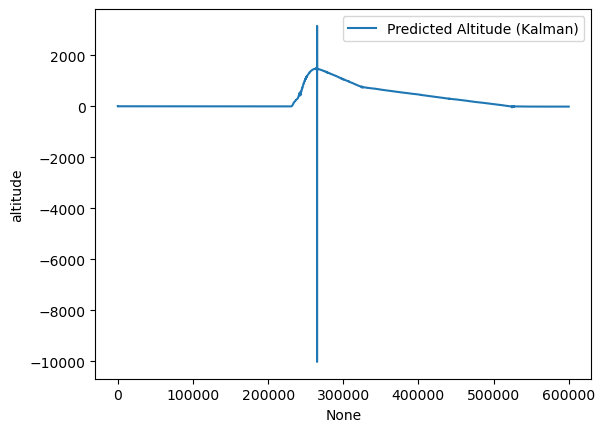

In [128]:
df_pred = pd.DataFrame(predicted_altitude, columns =['altitude'])

sns.lineplot(x=df_pred.index, y='altitude', data=df_pred, label='Predicted Altitude (Kalman)')

<Axes: xlabel='None', ylabel='barometer.altitude'>

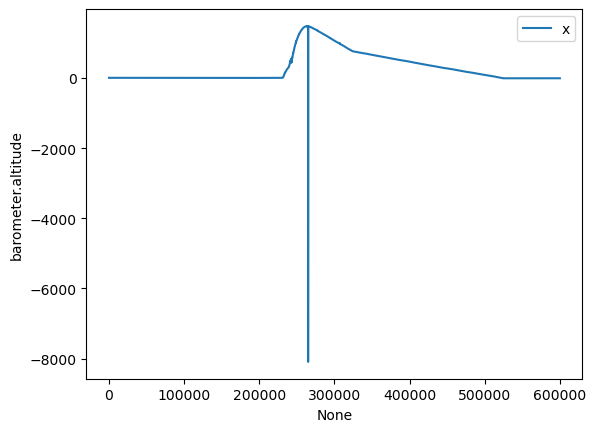

In [129]:
sns.lineplot(x=df_pred.index, y='barometer.altitude', data=df[:600000], label = 'x')